# Customer Segmentation
Customer segmentation is the strategic process of identifying and grouping a company's existing and potential customers into distinct subsets based on meaningful and actionable shared characteristics. These characteristics can include demographics, behavior, psychographics, and geographic location, among others. The goal of customer segmentation is to tailor marketing, sales, and service efforts to meet the specific needs and preferences of each group, ultimately leading to increased customer satisfaction, loyalty, and profitability. 

## Why is Customer Segmentation Important?

- **Personalized Marketing**: Enables the creation of targeted and relevant marketing campaigns.
- **Improved Customer Experience**: Delivers tailored experiences that resonate with specific customer needs.
- **Increased Customer Loyalty**: Makes customers feel understood and valued, fostering stronger relationships.
- **Higher Conversion Rates**: Targeted offers are more likely to lead to sales.
- **Optimized Resource Allocation**: Focuses marketing and sales efforts on the most promising customer groups.
- **Better Product Development**: Provides insights into customer needs and preferences, informing product innovation.


# About this project
____

This notebook aims at analyzing the content of an E-commerce database that lists purchases made by $\sim$4000 customers over a period of one year (from 2010/12/01 to 2011/12/09). Based on this analysis, we'll be able to anticipate the purchases that will be made by a new customer, during the following year and this, from its first purchase. <br>



___
**1. Data Preparation**

**2. Exploring the content of variables**

   - 2.1 Countries
   - 2.2 Customers and products
       * 2.2.1 Cancelling orders
       * 2.2.2 StockCode
       * 2.2.3 Basket price

**3. Insight on product categories**

   - 3.1 Product description 
   - 3.2 Defining product categories 
       * 3.2.1 Data encoding
       * 3.2.2 Clusters of products
       * 3.2.3 Characterizing the content of clusters
   
**4. Customer categories**

   - 4.1 Formating data
       * 4.1.1 Grouping products 
       * 4.1.2 Time spliting of the dataset
       * 4.1.3 Grouping orders 
   - 4.2 Creating customer categories
       * 4.2.1 Data enconding
       * 4.2.2 Creating categories

**5. Classifying customers**

   - 5.1 Support Vector Machine Classifier (SVC)
       * 5.1.1 Confusion matrix
       * 5.1.2 Leraning curves 
   - 5.2 Logistic regression 
   - 5.3 k-Nearest Neighbors
   - 5.4 Decision Tree
   - 5.5 Random Forest
   - 5.6 AdaBoost
   - 5.7 Gradient Boosting Classifier
   - 5.8 Let's vote !(Ensemble Methods)
   
**6. Testing the predictions**

**7. Conclusion**

## 1. Data preparation

As a first step, load all the modules and libraries that will be used in this notebook:

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, nltk, warnings
import matplotlib.cm as cm
import itertools
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import neighbors, linear_model, svm, tree, ensemble
from wordcloud import WordCloud, STOPWORDS
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
from IPython.display import display, HTML
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
%matplotlib inline

Then, we load the data. After that, we also display some basic informations on the content of the dataframe such as the type of the various variables, the number of null values, their percentage with respect to the total number of entries and the number of unique values in each column.

In [2]:
#__________________
# read the datafile
df_initial = pd.read_csv('data.csv',encoding="ISO-8859-1",
                         dtype={'CustomerID': str,'InvoiceID': str})
print('Dataframe dimensions:', df_initial.shape)
#______
df_initial['InvoiceDate'] = pd.to_datetime(df_initial['InvoiceDate'])
#____________________________________________________________
# gives some infos on columns types and numer of null values
tab_info=pd.DataFrame(df_initial.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()/df_initial.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
display(tab_info)
#__________________
# show first lines
display(df_initial[:5])
#show no. of unique values in each column
display(df_initial.nunique())

Dataframe dimensions: (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
column type,object,object,object,int64,datetime64[ns],float64,object,object
null values (nb),0,0,1454,0,0,0,135080,0
null values (%),0.0,0.0,0.268311,0.0,0.0,0.0,24.926694,0.0


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


InvoiceNo      25900
StockCode       4070
Description     4223
Quantity         722
InvoiceDate    23260
UnitPrice       1630
CustomerID      4372
Country           38
dtype: int64

While looking at the number of null values in the dataframe, it is interesting to note that $\sim$25% of the entries are not assigned to a particular customer. With the data available, it is impossible to impute values for the user and these entries are thus useless for the current exercise. So, we need to delete them from the dataframe:

In [3]:
df_initial.dropna(axis = 0, subset = ['CustomerID'], inplace = True)
print('Dataframe dimensions:', df_initial.shape)
#____________________________________________________________
# gives some infos on columns types and numer of null values
tab_info=pd.DataFrame(df_initial.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()/df_initial.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
display(tab_info)

Dataframe dimensions: (406829, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
column type,object,object,object,int64,datetime64[ns],float64,object,object
null values (nb),0,0,0,0,0,0,0,0
null values (%),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


By removing these entries, we end up with a dataframe filled at 100% for all variables! Finally, we check for duplicate entries and delete them:

In [4]:
print('No. of duplicate entries: {}'.format(df_initial.duplicated().sum()))
df_initial.drop_duplicates(inplace = True)

No. of duplicate entries: 5225


___
## 2. Exploring the content of variables

This dataframe contains 8 variables: 

**InvoiceNo**: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.  <br>
**StockCode**: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product. <br>
**Description**: Product (item) name. Nominal. <br>
**Quantity**: The quantities of each product (item) per transaction. Numeric.	<br>
**InvoiceDate**: Invoice Date and time. Numeric, the day and time when each transaction was generated. <br>
**UnitPrice**: Unit price. Numeric, Product price per unit in sterling. <br>
**CustomerID**: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer. <br>
**Country**: Country name. Nominal, the name of the country where each customer resides.<br>

___
### 2.1 Countries

Let's look at the countries from where orders were made:

In [5]:
temp = df_initial[['CustomerID', 'InvoiceNo', 'Country']].groupby(['CustomerID', 'InvoiceNo', 'Country']).count()
temp = temp.reset_index(drop = False)
countries = temp['Country'].value_counts()
print('Number of distinct countries in the dataframe: {}'.format(len(countries)))

Number of distinct countries in the dataframe: 37


and show the result on a chloropleth map:

In [6]:
data = dict(type='choropleth',
locations = countries.index,
locationmode = 'country names', z = countries,
text = countries.index, colorbar = {'title':'Order nb.'},
colorscale=[[0, 'rgb(224,255,255)'],
            [0.01, 'rgb(166,206,227)'], [0.02, 'rgb(31,120,180)'],
            [0.03, 'rgb(178,223,138)'], [0.05, 'rgb(51,160,44)'],
            [0.10, 'rgb(251,154,153)'], [0.20, 'rgb(255,255,0)'],
            [1, 'rgb(227,26,28)']],    
reversescale = False)
#_______________________
layout = dict(title='Number of orders per country',
geo = dict(showframe = True, projection={'type':'mercator'}))
#______________
choromap = go.Figure(data = [data], layout = layout)
iplot(choromap, validate=False)

We see that the dataset is largely dominated by orders made from the UK.

___
### 2.2 Customers and products

The dataframe contains $\sim$400,000 entries. What are the number of users and products in these entries ?

In [7]:
pd.DataFrame([{'products': len(df_initial['StockCode'].value_counts()),    
               'transactions': len(df_initial['InvoiceNo'].value_counts()),
               'customers': len(df_initial['CustomerID'].value_counts()),  
              }], columns = ['products', 'transactions', 'customers'], index = ['quantity'])

,products,transactions,customers
quantity,3684,22190,4372


It can be seen that the data concern 4372 users and that they bought 3684 different products. The total number of transactions carried out is of the order of $\sim$22'000.

Now we will determine the number of products purchased in every transaction:

In [8]:
temp = df_initial.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
nb_products_per_basket[:10].sort_values('CustomerID')

,CustomerID,InvoiceNo,Number of products
0,12346,541431,1
1,12346,C541433,1
2,12347,537626,31
3,12347,542237,29
4,12347,549222,24
5,12347,556201,18
6,12347,562032,22
7,12347,573511,47
8,12347,581180,11
9,12348,539318,17


The first 10 rows of this list shows several things worthy of interest:
- the existence of entries with the prefix C for the **InvoiceNo** variable: this indicates transactions that have been cancelled
- the existence of users who only came once and only purchased one product (e.g. nº12346)
- the existence of frequent users that buy a large number of items at each order

___
#### 2.2.1 Cancelling orders

First of all, we count the number of transactions corresponding to cancelled orders:

In [9]:
nb_products_per_basket['order_cancelled'] = nb_products_per_basket['InvoiceNo'].apply(lambda x:int('C' in x))
display(nb_products_per_basket[:5])
#______________________________________________________________________________________________
n1 = nb_products_per_basket['order_cancelled'].sum()
n2 = nb_products_per_basket.shape[0]
print('Number of orders cancelled: {}/{} ({:.2f}%) '.format(n1, n2, n1/n2*100))

,CustomerID,InvoiceNo,Number of products,order_cancelled
0,12346,541431,1,0
1,12346,C541433,1,1
2,12347,537626,31,0
3,12347,542237,29,0
4,12347,549222,24,0


Number of orders cancelled: 3654/22190 (16.47%) 


We note that the number of cancellations is quite large ($\sim$16% of the total number of transactions).
Now, let's look at the first 5 entries of the dataframe:

In [10]:
# Sort the dataframe by CustomerID in ascending order and display first 5 rows
display(df_initial.sort_values('CustomerID')[:5])

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346,United Kingdom
286623,562032,22375,AIRLINE BAG VINTAGE JET SET BROWN,4,2011-08-02 08:48:00,4.25,12347,Iceland
72260,542237,84991,60 TEATIME FAIRY CAKE CASES,24,2011-01-26 14:30:00,0.55,12347,Iceland
14943,537626,22772,PINK DRAWER KNOB ACRYLIC EDWARDIAN,12,2010-12-07 14:57:00,1.25,12347,Iceland


On these few lines, we see that when an order is cancelled, we have another transactions in the dataframe, mostly identical except for the **Quantity** and **InvoiceDate** variables. Let's check if this is true for all the entries.
To do this, we locate the entries that indicate a negative quantity and check if there is *systematically* an order indicating the same quantity (but positive), with the same description (**CustomerID**, **Description** and **UnitPrice**):

In [11]:
df_check = df_initial[df_initial['Quantity'] < 0][['CustomerID','Quantity',
                                                   'StockCode','Description','UnitPrice']]
for index, col in  df_check.iterrows():
    if df_initial[(df_initial['CustomerID'] == col[0]) & (df_initial['Quantity'] == -col[1]) 
                & (df_initial['Description'] == col[2])].shape[0] == 0: 
        print(df_check.loc[index])
        print(15*'-'+'>'+' HYPOTHESIS NOT FULFILLED')
        break

CustomerID        14527
Quantity             -1
StockCode             D
Description    Discount
UnitPrice          27.5
Name: 141, dtype: object
---------------> HYPOTHESIS NOT FULFILLED


We see that the initial hypothesis is not fulfilled because of the existence of a  '_Discount_' entry. We check the hypothesis again but this time discarding the '_Discount_' entries:

In [12]:
df_check = df_initial[(df_initial['Quantity'] < 0) & (df_initial['Description'] != 'Discount')][
                                 ['CustomerID','Quantity','StockCode',
                                  'Description','UnitPrice']]

for index, col in  df_check.iterrows():
    if df_initial[(df_initial['CustomerID'] == col[0]) & (df_initial['Quantity'] == -col[1]) 
                & (df_initial['Description'] == col[2])].shape[0] == 0: 
        print(index, df_check.loc[index])
        print(15*'-'+'>'+' HYPOTHESIS NOT FULFILLED')
        break

154 CustomerID                               15311
Quantity                                    -1
StockCode                               35004C
Description    SET OF 3 COLOURED  FLYING DUCKS
UnitPrice                                 4.65
Name: 154, dtype: object
---------------> HYPOTHESIS NOT FULFILLED


Again, we find that the initial hypothesis is not verified. Hence, cancellations do not necessarily correspond to orders that would have been made beforehand.

At this point, we decide to create a new variable in the dataframe that indicates if part of the command has been cancelled. For the cancellations without counterparts, a few of them are probably due to the fact that the buy orders were  performed before December 2010 (the point of entry of the database). Below, we make a census of the cancelled orders and check for the existence of counterparts:

In [13]:
# this part is highly compute-intensive, so it may take several minutes to run
df_cleaned = df_initial.copy(deep = True)
df_cleaned['QuantityCancelled'] = 0

entry_to_remove = [] ; doubtful_entry = []

for index, col in  df_initial.iterrows():
    if (col['Quantity'] > 0) or col['Description'] == 'Discount': continue        
    df_test = df_initial[(df_initial['CustomerID'] == col['CustomerID']) &
                         (df_initial['StockCode']  == col['StockCode']) & 
                         (df_initial['InvoiceDate'] < col['InvoiceDate']) & 
                         (df_initial['Quantity']   > 0)].copy()
    #_________________________________
    # Cancellation WITHOUT counterpart
    if (df_test.shape[0] == 0): 
        doubtful_entry.append(index)
    #________________________________
    # Cancellation WITH a counterpart
    elif (df_test.shape[0] == 1): 
        index_order = df_test.index[0]
        df_cleaned.loc[index_order, 'QuantityCancelled'] = -col['Quantity']
        entry_to_remove.append(index)        
    #______________________________________________________________
    # Various counterparts exist in orders: we delete the last one
    elif (df_test.shape[0] > 1): 
        df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
        for ind, val in df_test.iterrows():
            if val['Quantity'] < -col['Quantity']: continue
            df_cleaned.loc[ind, 'QuantityCancelled'] = -col['Quantity']
            entry_to_remove.append(index) 
            break            

In the above function, we checked the two cases:
1. a cancel order exists without counterpart
2. there's at least one counterpart with the exact same quantity

The index of the corresponding cancel order are respectively kept in the `doubtful_entry` and `entry_to_remove` lists whose sizes are:

In [14]:
print("entry_to_remove: {}".format(len(entry_to_remove)))
print("doubtful_entry: {}".format(len(doubtful_entry)))

entry_to_remove: 7521
doubtful_entry: 1226


Among these entries, the lines listed in the *doubtful_entry* list correspond to the entries indicating a cancellation but for which there is no command beforehand. In practice, we decide to delete all of these entries, which count respectively for  $\sim$1.4% and 0.2% of the dataframe entries.

Now we check the number of entries that correspond to cancellations and that have not been deleted with the previous filter:

In [15]:
df_cleaned.drop(entry_to_remove, axis = 0, inplace = True)
df_cleaned.drop(doubtful_entry, axis = 0, inplace = True)
remaining_entries = df_cleaned[(df_cleaned['Quantity'] < 0) & (df_cleaned['StockCode'] != 'D')]
print("no. of entries to delete: {}".format(remaining_entries.shape[0]))
remaining_entries[:5]

no. of entries to delete: 48


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCancelled
77598,C542742,84535B,FAIRY CAKES NOTEBOOK A6 SIZE,-94,2011-01-31 16:26:00,0.65,15358,United Kingdom,0
90444,C544038,22784,LANTERN CREAM GAZEBO,-4,2011-02-15 11:32:00,4.95,14659,United Kingdom,0
111968,C545852,22464,HANGING METAL HEART LANTERN,-5,2011-03-07 13:49:00,1.65,14048,United Kingdom,0
116064,C546191,47566B,TEA TIME PARTY BUNTING,-35,2011-03-10 10:57:00,0.70,16422,United Kingdom,0
132642,C547675,22263,FELT EGG COSY LADYBIRD,-49,2011-03-24 14:07:00,0.66,17754,United Kingdom,0


If one looks, for example, at the purchases of the consumer of one of the above entries and corresponding to the same product as that of the cancellation, one observes that the quantity cancelled is greater than the sum of the previous purchases.

In [16]:
df_cleaned[(df_cleaned['CustomerID'] == '14048') & (df_cleaned['StockCode'] == '22464')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCancelled
84247,543371,22464,HANGING METAL HEART LANTERN,3,2011-02-07 14:53:00,1.65,14048,United Kingdom,0
84259,543371,22464,HANGING METAL HEART LANTERN,1,2011-02-07 14:53:00,1.65,14048,United Kingdom,0
111968,C545852,22464,HANGING METAL HEART LANTERN,-5,2011-03-07 13:49:00,1.65,14048,United Kingdom,0


___
#### 2.2.2 StockCode

Above, it has been seen that some values of the **StockCode** variable indicate a particular transaction (i.e. D for _Discount_). We check the contents of this variable by looking for the set of codes that would contain only letters:

In [17]:
list_special_codes = df_cleaned[df_cleaned['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]['StockCode'].unique()
list_special_codes

array(['POST', 'D', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT'],
      dtype=object)

In [18]:
for code in list_special_codes:
    print("{:<15} -> {:<30}".format(code, df_cleaned[df_cleaned['StockCode'] == code]['Description'].unique()[0]))

POST            -> POSTAGE                       
D               -> Discount                      
C2              -> CARRIAGE                      
M               -> Manual                        
BANK CHARGES    -> Bank Charges                  
PADS            -> PADS TO MATCH ALL CUSHIONS    
DOT             -> DOTCOM POSTAGE                


We see that there are several types of peculiar transactions, related to port charges, bank charges, etc


___
#### 2.2.3 Basket Price

We create a new variable that indicates the total price of every purchase:

In [19]:
df_cleaned['TotalPrice'] = df_cleaned['UnitPrice'] * (df_cleaned['Quantity'] - df_cleaned['QuantityCancelled'])
df_cleaned.sort_values('CustomerID')[:5]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCancelled,TotalPrice
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom,74215,0.0
148288,549222,22375,AIRLINE BAG VINTAGE JET SET BROWN,4,2011-04-07 10:43:00,4.25,12347,Iceland,0,17.0
428971,573511,22698,PINK REGENCY TEACUP AND SAUCER,12,2011-10-31 12:25:00,2.95,12347,Iceland,0,35.4
428970,573511,47559B,TEA TIME OVEN GLOVE,10,2011-10-31 12:25:00,1.25,12347,Iceland,0,12.5
428969,573511,47567B,TEA TIME KITCHEN APRON,6,2011-10-31 12:25:00,5.95,12347,Iceland,0,35.7


Each entry of the dataframe indicates prizes for a single kind of product. Hence, orders are split on several lines. We collect all the purchases made during a single order to recover the total order prize:

In [20]:
#___________________________________________
# sum of purchases / user & order
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
basket_price = temp.rename(columns = {'TotalPrice':'Basket Price'})
#_____________________
# order date
df_cleaned['InvoiceDate_int'] = df_cleaned['InvoiceDate'].astype('int64')
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()
df_cleaned.drop('InvoiceDate_int', axis = 1, inplace = True)
basket_price.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])
#______________________________________
# selection of significant entries:
basket_price = basket_price[basket_price['Basket Price'] > 0]
basket_price.sort_values('CustomerID')[:6]

,CustomerID,InvoiceNo,Basket Price,InvoiceDate
1,12347,537626,711.79,2010-12-07 14:57:00.000000000
2,12347,542237,475.39,2011-01-26 14:29:59.999999744
3,12347,549222,636.25,2011-04-07 10:43:00.000000000
4,12347,556201,382.52,2011-06-09 13:01:00.000000000
5,12347,562032,584.91,2011-08-02 08:48:00.000000000
6,12347,573511,1294.32,2011-10-31 12:25:00.000000000


In order to have a global view of the type of order performed in this dataset, we determine how the purchases are divided according to total prizes:

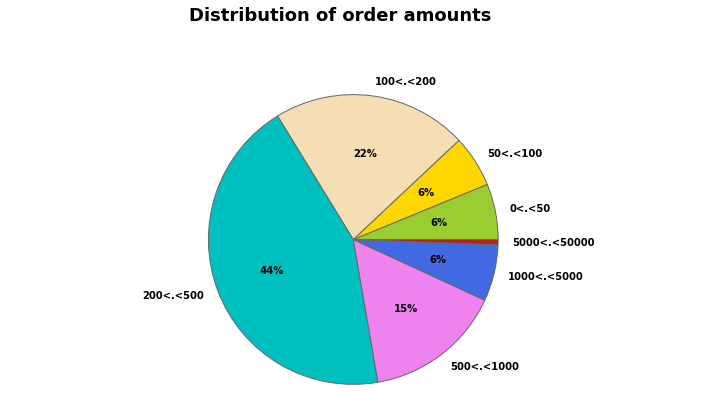

In [21]:
#____________________
# Purchase count
price_range = [0, 50, 100, 200, 500, 1000, 5000, 50000]
count_price = []
for i, price in enumerate(price_range):
    if i == 0: continue
    val = basket_price[(basket_price['Basket Price'] < price) &
                       (basket_price['Basket Price'] > price_range[i-1])]['Basket Price'].count()
    count_price.append(val)
#____________________________________________
# Representation of the number of purchases / amount        
plt.rc('font', weight='bold')
f, ax = plt.subplots(figsize=(11, 6))
colors = ['yellowgreen', 'gold', 'wheat', 'c', 'violet', 'royalblue','firebrick']
labels = [ '{}<.<{}'.format(price_range[i-1], s) for i,s in enumerate(price_range) if i != 0]
sizes  = count_price
explode = [0.0 if sizes[i] < 100 else 0.0 for i in range(len(sizes))]
ax.pie(sizes, explode = explode, labels=labels, colors = colors,
       autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '',
       shadow = False, startangle=0)
ax.axis('equal')
f.text(0.5, 1.01, "Distribution of order amounts", ha='center', fontsize = 18);

It can be seen that the vast majority of orders concern relatively large purchases given that $\sim$65% of purchases are of order amount more than £ 200.

____
## 3. Insight on product categories

In the dataframe, products are uniquely identified through the **StockCode** variable. A short description of the products is given in the **Description** variable. In this section, we intend to use the content of this latter variable in order to group the products into different categories.

___
### 3.1 Products Description

As a first step, we extract the information from the **Description** variable  that will prove useful. To do this, we use the following function:

In [22]:
is_noun = lambda pos: pos[:2] == 'NN'

def keywords_inventory(dataframe, colonne = 'Description'):
    stemmer = nltk.stem.SnowballStemmer("english")
    keywords_roots  = dict()  # collect the words / root
    keywords_select = dict()  # association: root <-> keyword
    category_keys   = []
    count_keywords  = dict()
    icount = 0
    for s in dataframe[colonne]:
        if pd.isnull(s): continue
        lines = s.lower()
        tokenized = nltk.word_tokenize(lines)
        nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)] 
        
        for t in nouns:
            t = t.lower() ; racine = stemmer.stem(t)
            if racine in keywords_roots:                
                keywords_roots[racine].add(t)
                count_keywords[racine] += 1                
            else:
                keywords_roots[racine] = {t}
                count_keywords[racine] = 1
    
    for s in keywords_roots.keys():
        if len(keywords_roots[s]) > 1:  
            min_length = 1000
            for k in keywords_roots[s]:
                if len(k) < min_length:
                    clef = k ; min_length = len(k)            
            category_keys.append(clef)
            keywords_select[s] = clef
        else:
            category_keys.append(list(keywords_roots[s])[0])
            keywords_select[s] = list(keywords_roots[s])[0]
                   
    print("No. of keywords in variable '{}': {}".format(colonne,len(category_keys)))
    return category_keys, keywords_roots, keywords_select, count_keywords

This function takes as input the dataframe and analyzes the content of the **Description** column by performing the following operations:

- extract the names (proper, common) appearing in the products description
- for each name, extract the root of the word and aggregate the set of names associated with this particular root
- count the number of times each root appears in the dataframe
- when several words are listed for the same root, consider that the keyword associated with this root is the shortest name (this systematically selects the singular when there are singular/plural variants)

The first step of the analysis is to retrieve the list of products:

In [23]:
df_produits = pd.DataFrame(df_initial['Description'].unique()).rename(columns = {0:'Description'})

Once this list is created, use the function previously defined in order to analyze the description of the various products:

In [24]:
keywords, keywords_roots, keywords_select, count_keywords = keywords_inventory(df_produits)

No. of keywords in variable 'Description': 1483


The execution of this function returns three variables:
- `keywords`: the list of extracted keywords
- `keywords_roots`: a dictionary where the keys are the keywords roots and the values are the lists of words associated with those roots
- `count_keywords`: dictionary listing the number of times every word is used

At this point, we convert the `count_keywords` dictionary into a list, to sort the keywords according to their occurences:

In [25]:
list_products = []
for k,v in count_keywords.items():
    list_products.append([keywords_select[k],v])
list_products.sort(key = lambda x:x[1], reverse = True)

Using it, we create a representation of the most common keywords:

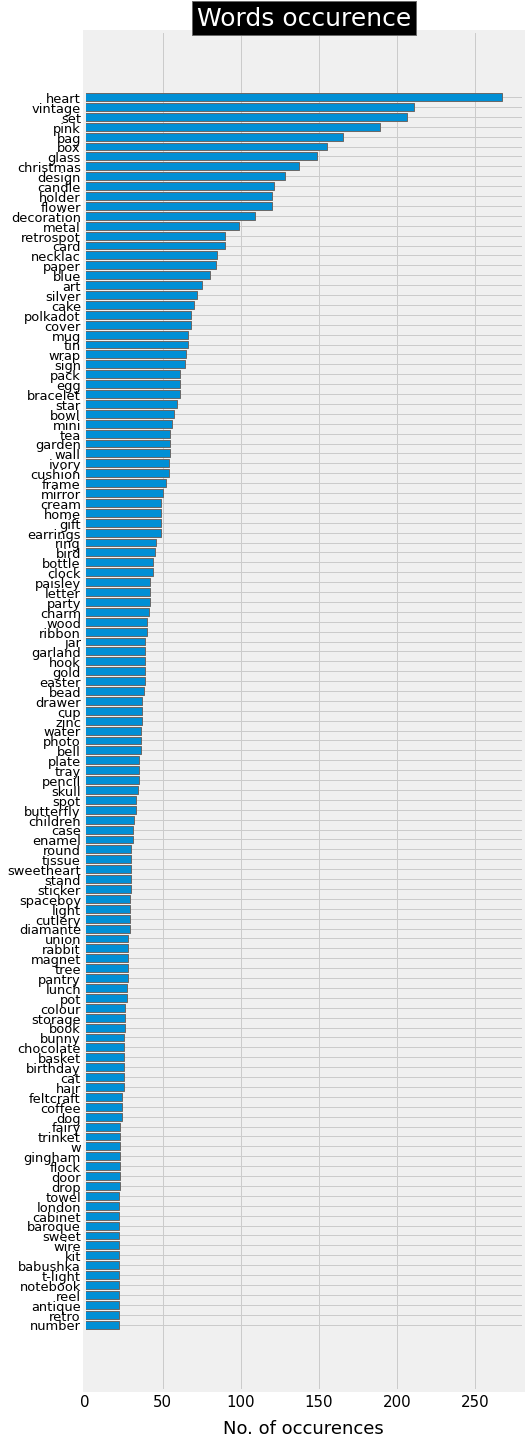

In [26]:
sorted_list = sorted(list_products, key = lambda x:x[1], reverse = True)
#_______________________________
plt.rc('font', weight='normal')
fig, ax = plt.subplots(figsize=(7, 25))
y_axis = [i[1] for i in sorted_list[:125]]
x_axis = [k for k,i in enumerate(sorted_list[:125])]
x_label = [i[0] for i in sorted_list[:125]]
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 13)
plt.yticks(x_axis, x_label)
plt.xlabel("No. of occurences", fontsize = 18, labelpad = 10)
ax.barh(x_axis, y_axis, align = 'center')
ax = plt.gca()
ax.invert_yaxis()
#_______________________________________________________________________________________
plt.title("Words occurence",bbox={'facecolor':'k', 'pad':5}, color='w',fontsize = 25)
plt.show()

___
### 3.2 Defining product categories 

The list that was obtained contains more than 1400 keywords and the most frequent ones appear in more than 200 products. However, while examining the content of the list, we note that some names are useless. Others do not carry information, like colors. Therefore, we must discard these words from the analysis that follows and also, consider only the words that appear more than 13 times.

In [27]:
list_products = []
for k,v in count_keywords.items():
    word = keywords_select[k]
    if word in ['pink', 'blue', 'tag', 'green', 'orange']: continue
    if len(word) < 3 or v < 13: continue
    if ('+' in word) or ('/' in word): continue
    list_products.append([word, v])
#______________________________________________________    
list_products.sort(key = lambda x:x[1], reverse = True)
print('preserved words:', len(list_products))

preserved words: 193


____
#### 3.2.1 Data encoding

Now we will use these keywords to create groups of product. Firstly, we define the matrix $X$ as:

   
|   | word 1  |  ...  | word j  | ...  | word N  |
|:-:|---|---|---|---|---|
| product 1  | $a_{1,1}$  |     |   |   | $a_{1,N}$  |
| ...        |            |     | ...  |   |   |
|product i   |    ...     |     | $a_{i,j}$    |   | ...  |
|...         |            |     |  ... |   |   |
| product M  | $a_{M,1}$  |     |   |   | $a_{M,N}$   |

where the coefficient $a_ {i, j}$ is 1 if the description of the product $i$ contains the word $j$, and 0 otherwise.

In [28]:
product_list = df_cleaned['Description'].unique()
X = pd.DataFrame()
for key, occurence in list_products:
    X.loc[:, key] = list(map(lambda x:int(key.upper() in x), product_list))

The $X$ matrix indicates the words contained in the description of the products using the *one-hot-encoding* principle. In practice, introducing the price range results in more balanced groups in terms of element numbers.
Hence, we add 6 extra columns to this matrix, where we indicate the price range of the products:

In [29]:
threshold = [0, 1, 2, 3, 5, 10]
label_col = []
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])
    label_col.append(col)
    X.loc[:, col] = 0

for i, prod in enumerate(product_list):
    price = df_cleaned[ df_cleaned['Description'] == prod]['UnitPrice'].mean()
    j = 0
    while price > threshold[j]:
        j+=1
        if j == len(threshold): break
    X.loc[i, label_col[j-1]] = 1

To choose the appropriate ranges, we check the number of products in the different groups:

In [30]:
print("{:<8} {:<20} \n".format('Price range', 'no. of products') + 20*'-')
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])    
    print("{:<10}  {:<20}".format(col, X.loc[:, col].sum()))

Price range no. of products      
--------------------
0<.<1       964                 
1<.<2       1009                
2<.<3       673                 
3<.<5       606                 
5<.<10      470                 
.>10        156                 


____
#### 3.2.2 Creating clusters of products

In this section, we will group the products into different classes. In the case of matrices with binary encoding, the most suitable metric for the calculation of distances is the [Hamming's metric](https://en.wikipedia.org/wiki/Distance_de_Hamming). Note that the **kmeans** method of sklearn uses a Euclidean distance that can be used, but it is not to the best choice in the case of categorical variables. However, in order to use the Hamming's metric, we need to use the [kmodes](https://pypi.python.org/pypi/kmodes/) package which is not available on the current platform. Hence, we use the **kmeans** method even if this is not the best choice.

In order to define (approximately) the number of clusters that best represents the data, we use the silhouette score:

In [31]:
matrix = X.values
for n_clusters in range(3,10):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 3 The average silhouette_score is : 0.10158702596012364
For n_clusters = 4 The average silhouette_score is : 0.1268004588393788
For n_clusters = 5 The average silhouette_score is : 0.14562442905455303
For n_clusters = 6 The average silhouette_score is : 0.14473539992077658
For n_clusters = 7 The average silhouette_score is : 0.1496577731781852
For n_clusters = 8 The average silhouette_score is : 0.14658096249360303
For n_clusters = 9 The average silhouette_score is : 0.13747574228060688


In practice, the scores obtained above can be considered equivalent since, depending on the run, scores of $ 0.1 \pm 0.05 $ will be obtained for all clusters with `n_clusters` $> $ 3 (we obtain slightly lower scores for the first cluster). On the other hand, we found that beyond 5 clusters, some clusters contained very few elements. We therefore choose to separate the dataset into 5 clusters. In order to ensure a good classification at every run of the notebook, we iterate untill we obtain the best possible silhouette score, which is, in the present case, around 0.15:

In [32]:
n_clusters = 5
silhouette_avg = -1
while silhouette_avg < 0.145:
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    
    #km = kmodes.KModes(n_clusters = n_clusters, init='Huang', n_init=2, verbose=0)
    #clusters = km.fit_predict(matrix)
    #silhouette_avg = silhouette_score(matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 5 The average silhouette_score is : 0.12071473295366611
For n_clusters = 5 The average silhouette_score is : 0.12670138195616623
For n_clusters = 5 The average silhouette_score is : 0.1456307025835938


___
#### 3.2.3  Characterizing the content of clusters

Check the number of elements in every class:

In [33]:
pd.Series(clusters).value_counts()

1    1159
4     964
2     673
3     606
0     476
dtype: int64


**_Silhouette intra-cluster score_**

In order to have an insight on the quality of the classification, we can represent the silhouette scores of each element of the different clusters. This is the purpose of the next figure which is taken from the [sklearn documentation](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html):

In [34]:
def graph_component_silhouette(n_clusters, lim_x, mat_size, sample_silhouette_values, clusters):
    plt.rcParams["patch.force_edgecolor"] = True
    plt.style.use('fivethirtyeight')
    mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
    #____________________________
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(8, 8)
    ax1.set_xlim([lim_x[0], lim_x[1]])
    ax1.set_ylim([0, mat_size + (n_clusters + 1) * 10])
    y_lower = 10
    for i in range(n_clusters):
        #___________________________________________________________________________________
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[clusters == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = cm.get_cmap("Spectral")
        color = cmap(float(i) / n_clusters)        
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                           facecolor=color, edgecolor=color, alpha=0.8)
        #____________________________________________________________________
        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.03, y_lower + 0.5 * size_cluster_i, str(i), color = 'red', fontweight = 'bold',
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round, pad=0.3'))
        #______________________________________
        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  

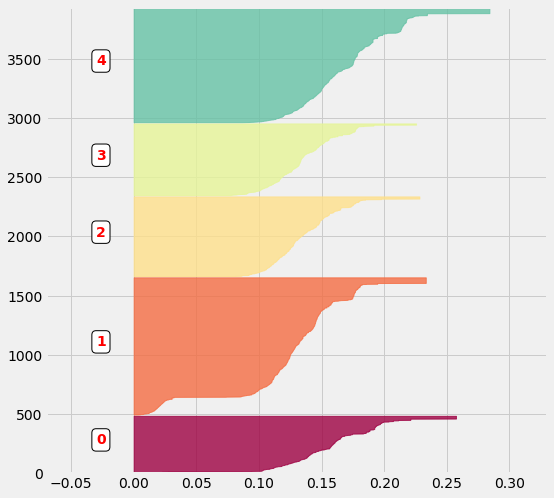

In [35]:
#____________________________________
# define individual silouhette scores
sample_silhouette_values = silhouette_samples(matrix, clusters)
#__________________
# and do the graph
graph_component_silhouette(n_clusters, [-0.07, 0.33], len(X), sample_silhouette_values, clusters)

** b/ _Word Cloud_**

Now we can have a look at the type of objects that each cluster represents. In order to obtain a global view of their contents, I determine which keywords are the most frequent in each of them

In [36]:
liste = pd.DataFrame(product_list)
list_words = [word for (word, occurence) in list_products]

occurence = [dict() for _ in range(n_clusters)]

for i in range(n_clusters):
    list_cluster = liste.loc[clusters == i]
    for word in list_words:
        if word in ['art', 'set', 'heart', 'pink', 'blue', 'tag']: continue
        occurence[i][word] = sum(list_cluster.loc[:, 0].str.contains(word.upper()))

Plot the top words(most frequent words) for each cluster

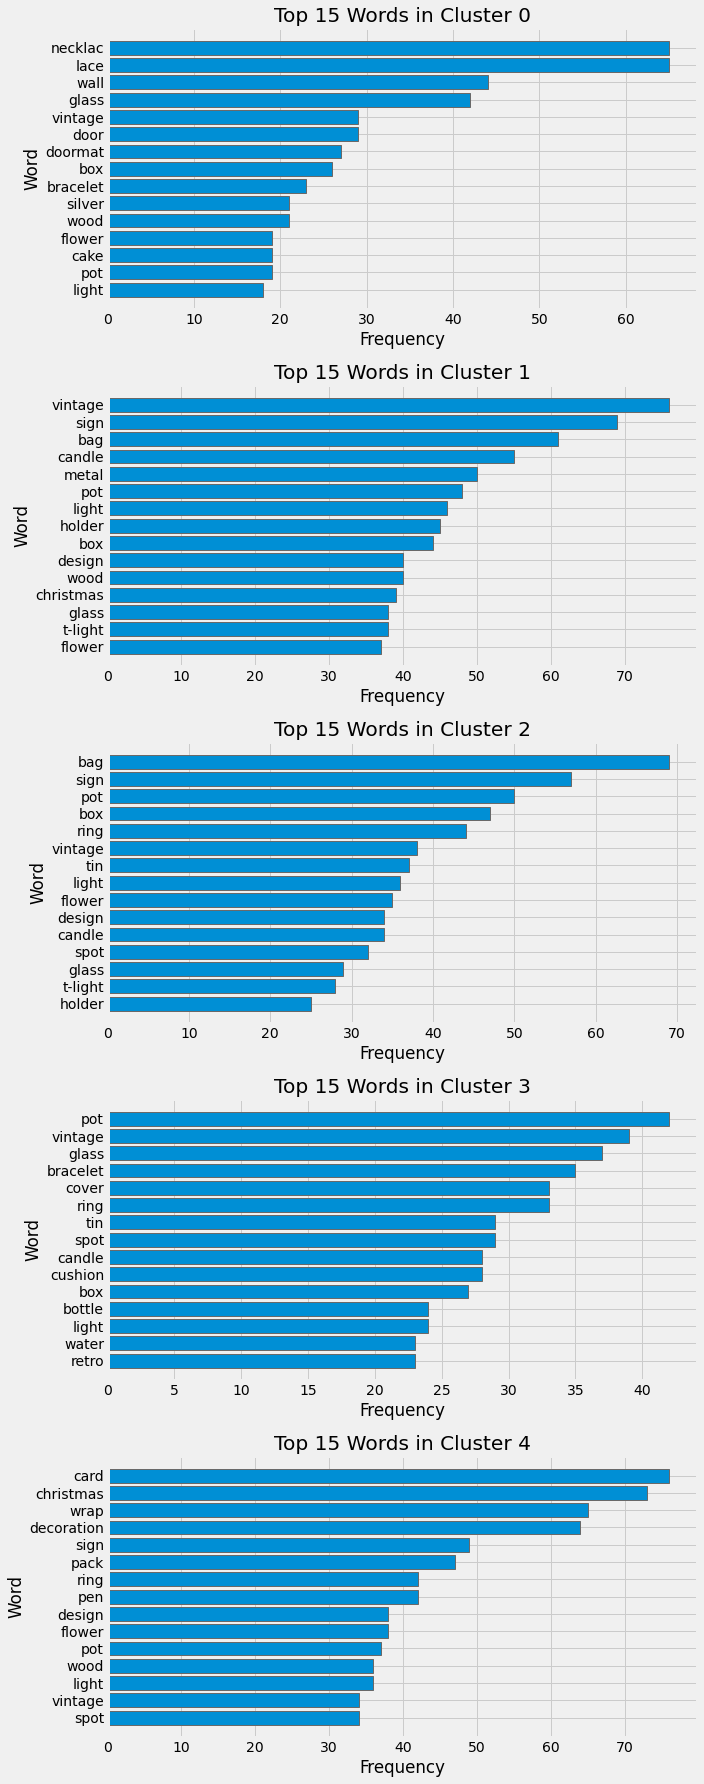

In [37]:
import matplotlib.pyplot as plt

def plot_top_words(occurence, n_top_words=10):
    """
    Plots bar charts of the top N most frequent words for each cluster.

    Args:
        occurence (list of dict): A list where each dictionary contains
                                   word: frequency pairs for a cluster.
        n_top_words (int): The number of top words to display for each cluster.
    """
    n_clusters = len(occurence)
    fig, axes = plt.subplots(nrows=n_clusters, ncols=1, figsize=(10, 5 * n_clusters))
    axes = axes.flatten()  # Flatten the axes array for easy indexing

    for i in range(n_clusters):
        cluster_occurrence = occurence[i]
        sorted_words = sorted(cluster_occurrence.items(), key=lambda item: item[1], reverse=True)
        top_words = sorted_words[:n_top_words]
        words, counts = zip(*top_words)

        axes[i].barh(words, counts)
        axes[i].set_title(f'Top {n_top_words} Words in Cluster {i}')
        axes[i].set_xlabel('Frequency')
        axes[i].set_ylabel('Word')
        axes[i].invert_yaxis()  # Display most frequent at the top

    plt.tight_layout()
    plt.show()

# 'occurence' is the list of dictionaries we generated previously
plot_top_words(occurence, n_top_words=15)

From this representation, we can see that for example, one of the clusters contains objects that could be associated with gifts (keywords: Christmas, packaging, card, ...). Another cluster would rather contain luxury items and jewelry (keywords: necklace, bracelet, lace, silver, ...). Nevertheless, it can also be observed that many words appear in various clusters and it is therefore difficult to clearly distinguish them.

**_Principal Component Analysis_**

In order to ensure that these clusters are truly distinct, we look at their composition. Given the large number of variables of the initial matrix, let's first perform a PCA:

In [38]:
pca = PCA()
pca.fit(matrix)
pca_samples = pca.transform(matrix)

and then check for the amount of variance explained by each component:

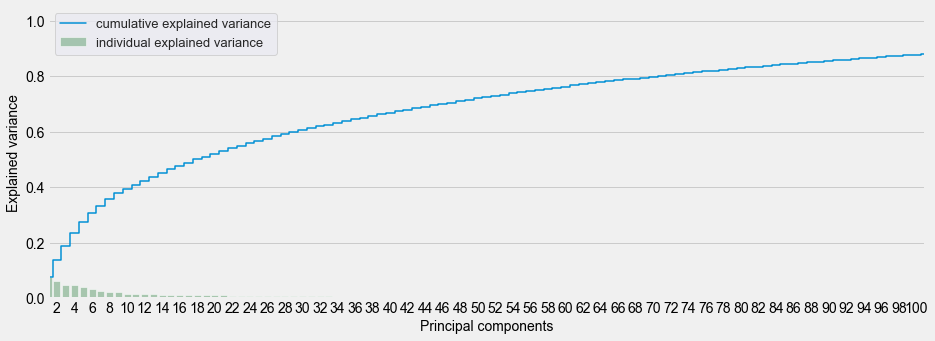

In [39]:
fig, ax = plt.subplots(figsize=(14, 5))
sns.set(font_scale=1)
plt.step(range(matrix.shape[1]), pca.explained_variance_ratio_.cumsum(), where='mid',
         label='cumulative explained variance')
sns.barplot(np.arange(1,matrix.shape[1]+1), pca.explained_variance_ratio_, alpha=0.5, color = 'g',
            label='individual explained variance')
plt.xlim(0, 100)

ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])

plt.ylabel('Explained variance', fontsize = 14)
plt.xlabel('Principal components', fontsize = 14)
plt.legend(loc='upper left', fontsize = 13);

We see that the number of components required to explain the data is extremely important: we need more than 100 components to explain 90% of the variance of the data. In practice, we decided to keep only a limited number of components since this decomposition is only performed to visualize the data:

In [40]:
pca = PCA(n_components=50)
matrix_9D = pca.fit_transform(matrix)
mat = pd.DataFrame(matrix_9D)
mat['cluster'] = pd.Series(clusters)

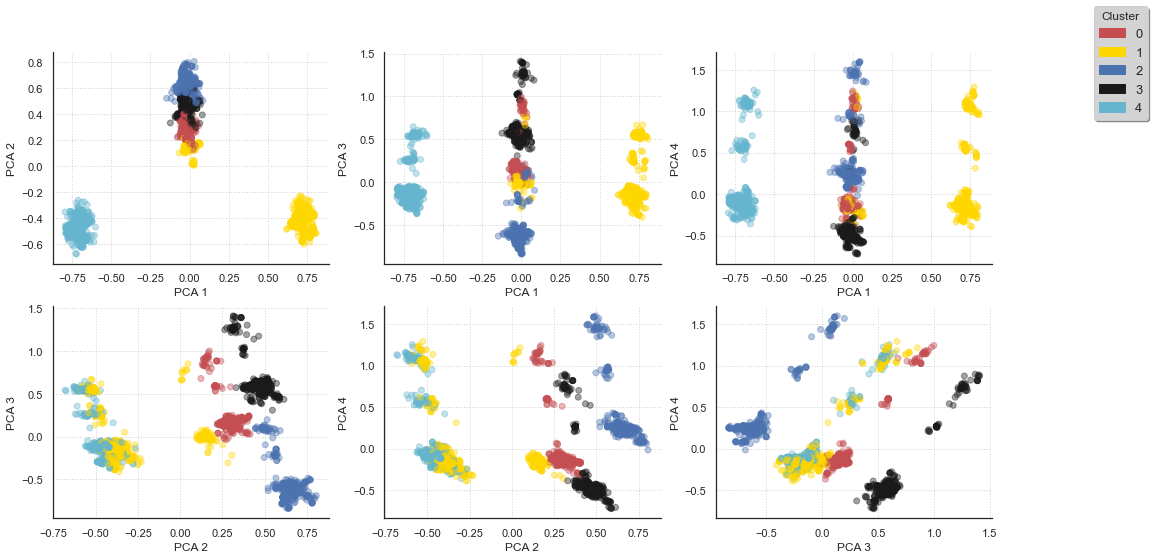

In [41]:
import matplotlib.patches as mpatches

sns.set_style("white")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})

LABEL_COLOR_MAP = {0:'r', 1:'gold', 2:'b', 3:'k', 4:'c', 5:'g'}
label_color = [LABEL_COLOR_MAP[l] for l in mat['cluster']]

fig = plt.figure(figsize = (15,8))
increment = 0
for ix in range(4):
    for iy in range(ix+1, 4):    
        increment += 1
        ax = fig.add_subplot(2,3,increment)
        ax.scatter(mat[ix], mat[iy], c= label_color, alpha=0.4) 
        plt.ylabel('PCA {}'.format(iy+1), fontsize = 12)
        plt.xlabel('PCA {}'.format(ix+1), fontsize = 12)
        ax.yaxis.grid(color='lightgray', linestyle=':')
        ax.xaxis.grid(color='lightgray', linestyle=':')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        if increment == 9: break
    if increment == 9: break
        
#_______________________________________________
# set the legend: abreviation -> airline name
comp_handler = []
for i in range(5):
    comp_handler.append(mpatches.Patch(color = LABEL_COLOR_MAP[i], label = i))

plt.legend(handles=comp_handler, bbox_to_anchor=(1.1, 0.97), 
           title='Cluster', facecolor = 'lightgrey',
           shadow = True, frameon = True, framealpha = 1,
           fontsize = 13, bbox_transform = plt.gcf().transFigure)

plt.show()

___
## 4. Customer categories

### 4.1 Formatting data

In the previous section, the different products were grouped in five clusters. In order to prepare the rest of the analysis, a first step consists in introducing this information into the dataframe. To do this, we have to create the categorical variable **categ_product** to indicate the cluster of each product :

In [42]:
corresp = dict()
for key, val in zip (product_list, clusters):
    corresp[key] = val 
#__________________________________________________________________________
df_cleaned['categ_product'] = df_cleaned.loc[:, 'Description'].map(corresp)

___
#### 4.1.1 Grouping products

In a second step, we create the **categ_N** variables (with $ N \in [0: 4]$) that contains the amount spent in each product category:

In [44]:
for i in range(5):
    col = 'categ_{}'.format(i)        
    df_temp = df_cleaned[df_cleaned['categ_product'] == i]
    price_temp = df_temp['UnitPrice'] * (df_temp['Quantity'] - df_temp['QuantityCancelled'])
    price_temp = price_temp.apply(lambda x:x if x > 0 else 0)
    df_cleaned.loc[:, col] = price_temp
    df_cleaned[col].fillna(0, inplace = True)
#__________________________________________________________________________________________________
df_cleaned[['InvoiceNo', 'Description', 'categ_product', 'categ_0', 'categ_1', 'categ_2', 'categ_3','categ_4']][:5]

,InvoiceNo,Description,categ_product,categ_0,categ_1,categ_2,categ_3,categ_4
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,2,0.0,0.0,15.3,0.00,0.0
1,536365,WHITE METAL LANTERN,3,0.0,0.0,0.0,20.34,0.0
2,536365,CREAM CUPID HEARTS COAT HANGER,3,0.0,0.0,0.0,22.00,0.0
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,3,0.0,0.0,0.0,20.34,0.0
4,536365,RED WOOLLY HOTTIE WHITE HEART.,3,0.0,0.0,0.0,20.34,0.0


Up to now, the information related to a single order was split over several lines of the dataframe (one line per product). We collect the information related to a particular order and put in in a single entry. Then, we create a new dataframe that contains, for each order, the amount of the basket, as well as the way it is distributed over the 5 categories of products:

In [45]:
#___________________________________________
# sum of purchases / user & order
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()

basket_price = temp.rename(columns = {'TotalPrice':'Basket Price'})

#____________________________________________________________
# percentage of order price / product category
for i in range(5):
    col = 'categ_{}'.format(i)
    temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=True)[col].sum() # Set index to True
    basket_price = basket_price.set_index(['CustomerID', 'InvoiceNo'], drop=False) # Ensure index is set in basket_price
    basket_price.loc[:, col] = temp
    basket_price = basket_price.reset_index(drop=True) # Reset index if needed for subsequent operations
#_____________________
# order date
df_cleaned['InvoiceDate_int'] = df_cleaned['InvoiceDate'].astype('int64')
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()
df_cleaned.drop('InvoiceDate_int', axis = 1, inplace = True)
basket_price.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])
#______________________________________
# selection of significant entries:
basket_price = basket_price[basket_price['Basket Price'] > 0]
basket_price.sort_values('CustomerID', ascending = True)[:5]

,CustomerID,InvoiceNo,Basket Price,categ_0,categ_1,categ_2,categ_3,categ_4,InvoiceDate
1,12347,537626,711.79,124.44,187.20,83.40,293.35,23.40,2010-12-07 14:57:00.000000000
2,12347,542237,475.39,0.00,168.75,53.10,169.20,84.34,2011-01-26 14:29:59.999999744
3,12347,549222,636.25,0.00,369.15,71.10,115.00,81.00,2011-04-07 10:43:00.000000000
4,12347,556201,382.52,19.90,74.40,78.06,168.76,41.40,2011-06-09 13:01:00.000000000
5,12347,562032,584.91,97.80,147.95,119.70,158.16,61.30,2011-08-02 08:48:00.000000000


#### 4.1.2 Separation of data over time

The dataframe `basket_price` contains information for a period of 12 months. Later, one of the objectives will be to develop a model capable of characterizing and anticipating the habits of the customers visiting the site and this, from their first visit. In order to be able to test the model in a realistic way, we split the data set by retaining the first 10 months to develop the model and the following two months to test it:

In [46]:
# range of InvoiceDate
print(basket_price['InvoiceDate'].min(), '->',  basket_price['InvoiceDate'].max())

2010-12-01 08:26:00 -> 2011-12-09 12:50:00


In [47]:
set_entrainement = basket_price[basket_price['InvoiceDate'] < pd.Timestamp(datetime.date(2011, 10, 1))]
set_test         = basket_price[basket_price['InvoiceDate'] >= pd.Timestamp(datetime.date(2011, 10, 1))]
basket_price = set_entrainement.copy(deep = True)


____
#### 4.1.3 Consumer Order Combinations

In  second step, we group together the different entries that correspond to the same user, determining the number of purchases made by the user, as well as the minimum, maximum, average amounts and the total amount spent during all the visits:

In [48]:
#________________________________________________________________
# number of visits and stats on basketamount / users
transactions_per_user=basket_price.groupby(by=['CustomerID'])['Basket Price'].agg(['count','min','max','mean','sum'])
for i in range(5):
    col = 'categ_{}'.format(i)
    transactions_per_user.loc[:,col] = basket_price.groupby(by=['CustomerID'])[col].sum() /\
                                            transactions_per_user['sum']*100

transactions_per_user.reset_index(drop = False, inplace = True)
basket_price.groupby(by=['CustomerID'])['categ_0'].sum()
transactions_per_user.sort_values('CustomerID', ascending = True)[:5]

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4
0,12347,5,382.52,711.79,558.172000,2790.86,8.676179,33.948317,14.524555,32.408290,10.442659
1,12348,4,227.44,892.80,449.310000,1797.24,0.000000,61.983931,0.000000,0.000000,38.016069
2,12350,1,334.40,334.40,334.400000,334.40,0.000000,60.406699,27.900718,0.000000,11.692584
3,12352,6,144.35,840.30,345.663333,2073.98,14.301006,66.125517,3.370331,15.711338,0.491808
4,12353,1,89.00,89.00,89.000000,89.00,22.359551,57.752809,19.887640,0.000000,0.000000


Finally, we define two additional variables that give the number of days elapsed since the first purchase (** FirstPurchase **) and the number of days since the last purchase (** LastPurchase **):

In [49]:
last_date = basket_price['InvoiceDate'].max().date()

first_registration = pd.DataFrame(basket_price.groupby(by=['CustomerID'])['InvoiceDate'].min())
last_purchase      = pd.DataFrame(basket_price.groupby(by=['CustomerID'])['InvoiceDate'].max())

test  = first_registration.applymap(lambda x:(last_date - x.date()).days)
test2 = last_purchase.applymap(lambda x:(last_date - x.date()).days)

transactions_per_user.loc[:, 'LastPurchase'] = test2.reset_index(drop = False)['InvoiceDate']
transactions_per_user.loc[:, 'FirstPurchase'] = test.reset_index(drop = False)['InvoiceDate']

transactions_per_user[:5]

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,LastPurchase,FirstPurchase
0,12347,5,382.52,711.79,558.172000,2790.86,8.676179,33.948317,14.524555,32.408290,10.442659,59,297
1,12348,4,227.44,892.80,449.310000,1797.24,0.000000,61.983931,0.000000,0.000000,38.016069,5,288
2,12350,1,334.40,334.40,334.400000,334.40,0.000000,60.406699,27.900718,0.000000,11.692584,240,240
3,12352,6,144.35,840.30,345.663333,2073.98,14.301006,66.125517,3.370331,15.711338,0.491808,2,226
4,12353,1,89.00,89.00,89.000000,89.00,22.359551,57.752809,19.887640,0.000000,0.000000,134,134


A customer category of particular interest is that of customers who make only one purchase. One of the objectives may be, for example, to target these customers in order to retain them. In this part, we find that these types of customers represent 1/3 of the customers listed:

In [50]:
n1 = transactions_per_user[transactions_per_user['count'] == 1].shape[0]
n2 = transactions_per_user.shape[0]
print("No. of customers with single purchase: {:<2}/{:<5} ({:<2.2f}%)".format(n1,n2,n1/n2*100))

No. of customers with single purchase: 1445/3608  (40.05%)


___
### 4.2 Creation of customers categories

#### 4.2.1 Data encoding

The dataframe `transactions_per_user` contains a summary of all the commands that were made. Each entry in this dataframe corresponds to a particular client. We use this information to characterize the different types of customers and only keep a subset of variables:

In [51]:
list_cols = ['count','min','max','mean','categ_0','categ_1','categ_2','categ_3','categ_4']
#_____________________________________________________________
selected_customers = transactions_per_user.copy(deep = True)
matrix = selected_customers[list_cols].values

The different variables that we selected have quite different ranges of variation and before continuing the analysis, we must create a matrix where these data are standardized:

In [52]:
scaler = StandardScaler()
scaler.fit(matrix)
print('variables mean values: \n' + 90*'-' + '\n' , scaler.mean_)
scaled_matrix = scaler.transform(matrix)

variables mean values: 
------------------------------------------------------------------------------------------
 [  3.62305987 259.93189634 556.26687999 377.06036244  15.6945421
  32.75310053  21.19884856  16.37327913  13.98907929]


In the following, we will create clusters of customers. In practice, before creating these clusters, it is interesting to define a base of smaller dimension allowing to describe the `scaled_matrix` matrix. In this case, we will use this base in order to create a representation of the different clusters and thus verify the quality of the separation of the different groups. Therefore, we perform a PCA beforehand:

In [53]:
pca = PCA()
pca.fit(scaled_matrix)
pca_samples = pca.transform(scaled_matrix)

and represent the amount of variance explained by each of the components:

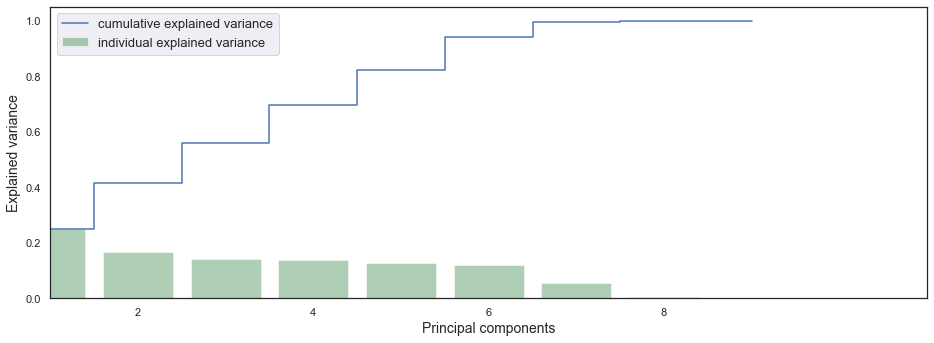

In [54]:
fig, ax = plt.subplots(figsize=(14, 5))
sns.set(font_scale=1)
plt.step(range(matrix.shape[1]), pca.explained_variance_ratio_.cumsum(), where='mid',
         label='cumulative explained variance')
sns.barplot(np.arange(1,matrix.shape[1]+1), pca.explained_variance_ratio_, alpha=0.5, color = 'g',
            label='individual explained variance')
plt.xlim(0, 10)

ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])

plt.ylabel('Explained variance', fontsize = 14)
plt.xlabel('Principal components', fontsize = 14)
plt.legend(loc='best', fontsize = 13);

___
#### 4.2.2 Creation of customer categories

Here, we define clusters of clients from the standardized matrix that was defined earlier and using the `k-means` algorithm from` scikit-learn`. We choose the number of clusters based on the silhouette score and we find that the best score is obtained with 11 clusters:

In [55]:
n_clusters = 11
kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=100)
kmeans.fit(scaled_matrix)
clusters_clients = kmeans.predict(scaled_matrix)
silhouette_avg = silhouette_score(scaled_matrix, clusters_clients)
print('score de silhouette: {:<.3f}'.format(silhouette_avg))

score de silhouette: 0.217


At first, I look at the number of customers in each cluster:

In [56]:
pd.DataFrame(pd.Series(clusters_clients).value_counts(), columns = ['no. of clients']).T

,1,8,3,4,10,0,5,9,2,6,7
no. of clients,1529,482,344,330,288,263,190,153,12,10,7


** _Report via the PCA_**

There is a certain disparity in the sizes of different groups that have been created. Hence we will now try to understand the content of these clusters in order to validate (or not) this particular separation. At first, we use the result of the PCA:

In [57]:
pca = PCA(n_components=6)
matrix_3D = pca.fit_transform(scaled_matrix)
mat = pd.DataFrame(matrix_3D)
mat['cluster'] = pd.Series(clusters_clients)

in order to create a representation of the various clusters:

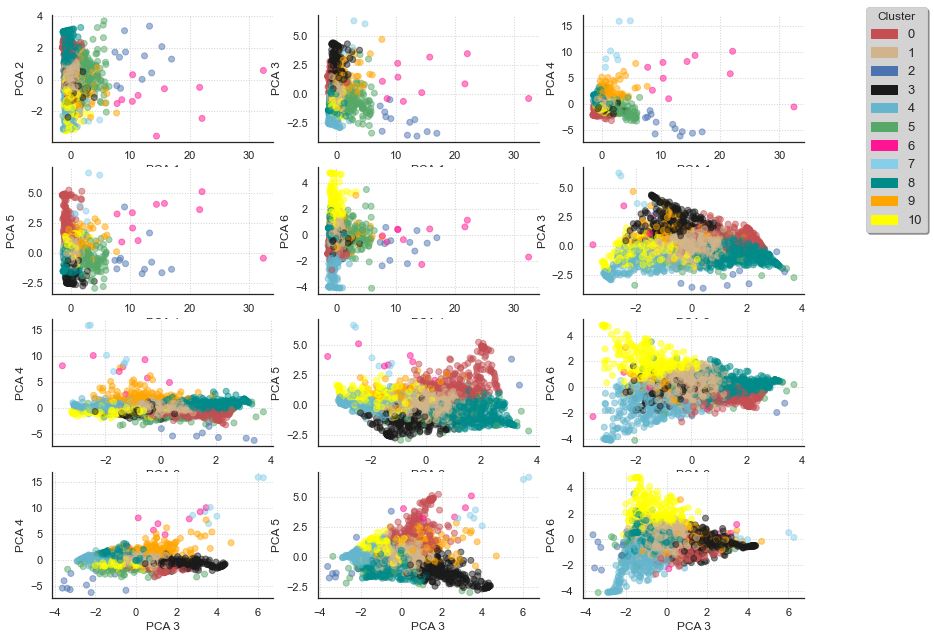

In [58]:
import matplotlib.patches as mpatches

sns.set_style("white")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})

LABEL_COLOR_MAP = {0:'r', 1:'tan', 2:'b', 3:'k', 4:'c', 5:'g', 6:'deeppink', 7:'skyblue', 8:'darkcyan', 9:'orange',
                   10:'yellow', 11:'tomato', 12:'seagreen'}
label_color = [LABEL_COLOR_MAP[l] for l in mat['cluster']]

fig = plt.figure(figsize = (12,10))
increment = 0
for ix in range(6):
    for iy in range(ix+1, 6):   
        increment += 1
        ax = fig.add_subplot(4,3,increment)
        ax.scatter(mat[ix], mat[iy], c= label_color, alpha=0.5) 
        plt.ylabel('PCA {}'.format(iy+1), fontsize = 12)
        plt.xlabel('PCA {}'.format(ix+1), fontsize = 12)
        ax.yaxis.grid(color='lightgray', linestyle=':')
        ax.xaxis.grid(color='lightgray', linestyle=':')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        if increment == 12: break
    if increment == 12: break
        
#_______________________________________________
# set the legend: abreviation -> airline name
comp_handler = []
for i in range(n_clusters):
    comp_handler.append(mpatches.Patch(color = LABEL_COLOR_MAP[i], label = i))

plt.legend(handles=comp_handler, bbox_to_anchor=(1.1, 0.9), 
           title='Cluster', facecolor = 'lightgrey',
           shadow = True, frameon = True, framealpha = 1,
           fontsize = 13, bbox_transform = plt.gcf().transFigure)

plt.tight_layout()

From this representation, it can be seen that the first principal component allow to separate the tiniest clusters from the rest. More generally, we see that there is always a representation in which two clusters will appear to be distinct.

**_Score de silhouette intra-cluster_**

As with product categories, another way to look at the quality of the separation is to look at silouhette scores within different clusters:

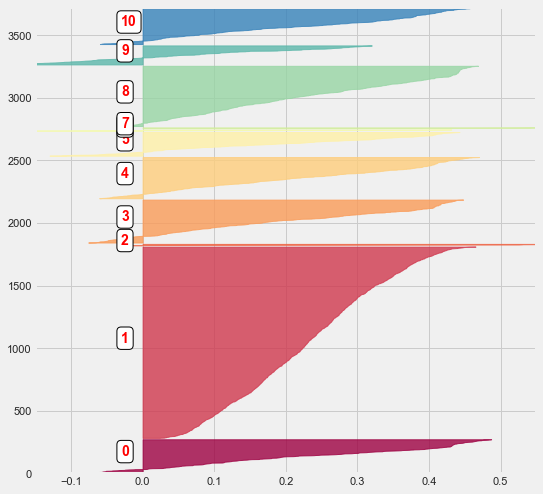

In [59]:
sample_silhouette_values = silhouette_samples(scaled_matrix, clusters_clients)
#____________________________________
# define individual silouhette scores
sample_silhouette_values = silhouette_samples(scaled_matrix, clusters_clients)
#__________________
# and do the graph
graph_component_silhouette(n_clusters, [-0.15, 0.55], len(scaled_matrix), sample_silhouette_values, clusters_clients)

**_Customers morphotype_**

At this stage, we have verified that the different clusters are indeed disjoint (at least, in a global way). It remains to understand the habits of the customers in each cluster. To do so, we start by adding to the `selected_customers` dataframe a variable that defines the cluster to which each client belongs:

In [60]:
selected_customers.loc[:, 'cluster'] = clusters_clients

Then, we average the contents of this dataframe by first selecting the different groups of clients. This gives access to, for example, the average baskets price, the number of visits or the total sums spent by the clients of the different clusters. We also determine the number of clients in each group (variable ** size **):

In [61]:
merged_df = pd.DataFrame()
for i in range(n_clusters):
    test = pd.DataFrame(selected_customers[selected_customers['cluster'] == i].mean())
    test = test.T.set_index('cluster', drop = True)
    test['size'] = selected_customers[selected_customers['cluster'] == i].shape[0]
    merged_df = pd.concat([merged_df, test])
#_____________________________________________________
merged_df.drop('CustomerID', axis = 1, inplace = True)
print('number of customers:', merged_df['size'].sum())

merged_df = merged_df.sort_values('sum')

number of customers: 3608


Finally, we re-organize the content of the dataframe by ordering the different clusters: first, in relation to the amount wpsent in each product category and then, according to the total amount spent:

In [62]:
list_index = []
for i in range(5):
    column = 'categ_{}'.format(i)
    list_index.append(merged_df[merged_df[column] > 45].index.values[0])
#___________________________________
list_index_reordered = list_index
list_index_reordered += [ s for s in merged_df.index if s not in list_index]
#___________________________________________________________
merged_df = merged_df.reindex(index = list_index_reordered)
merged_df = merged_df.reset_index(drop = False)
display(merged_df[['cluster', 'count', 'min', 'max', 'mean', 'sum', 'categ_0',
                   'categ_1', 'categ_2', 'categ_3', 'categ_4', 'size']])

,cluster,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,size
0,4.0,2.496970,192.154061,308.814758,244.608494,626.058455,53.380865,17.088317,11.282557,12.966561,5.298799,330
1,8.0,2.392116,197.981100,323.001122,253.927565,637.117450,7.228773,67.119672,10.748650,6.258683,8.647310,482
2,3.0,2.645349,207.342500,377.819390,289.129732,829.064564,8.477592,18.300852,57.661040,7.862015,7.698501,344
3,10.0,2.152778,202.304965,340.725972,264.983081,668.310035,10.775861,16.986832,14.370329,51.455621,6.465139,288
4,0.0,2.243346,192.369810,314.690228,245.732622,589.924297,5.351948,22.149879,11.221309,6.297748,54.979116,263
5,1.0,3.241988,223.257509,459.744899,332.137590,1085.553298,14.755315,33.241388,21.016219,17.266446,13.724508,1529
6,5.0,1.678947,1042.460158,1360.211216,1188.179373,2052.740795,13.591324,35.498901,21.605798,17.126018,12.178314,190
7,2.0,1.666667,3480.920833,3966.812500,3700.139306,5949.600000,18.278470,30.337563,13.322062,15.171169,22.890736,12
8,9.0,18.320261,87.490523,1601.115817,573.610351,9957.669020,15.608685,30.772188,25.332707,16.219650,12.087250,153
9,7.0,92.000000,10.985714,1858.250000,374.601553,34845.105714,17.721038,33.256402,22.527857,13.402971,13.117583,7


**_Customers morphology_**

Finally, we created a representation of the different morphotypes. To do this, we define a class to create "Radar Charts":

In [63]:
def _scale_data(data, ranges):
    (x1, x2) = ranges[0]
    d = data[0]
    return [(d - y1) / (y2 - y1) * (x2 - x1) + x1 for d, (y1, y2) in zip(data, ranges)]

class RadarChart():
    def __init__(self, fig, location, sizes, variables, ranges, n_ordinate_levels = 6):
        angles = np.arange(0, 360, 360./len(variables))
        ix, iy = location[:] ; size_x, size_y = sizes[:]

        axes = [fig.add_axes([ix, iy, size_x, size_y], polar = True,
                            label = "axes{}".format(i)) for i in range(len(variables))]

        _, text = axes[0].set_thetagrids(angles, labels = variables)

        for txt, angle in zip(text, angles):
            if angle > -1 and angle < 181:
                txt.set_rotation(angle - 90)
            else:
                txt.set_rotation(angle - 270)

        for ax in axes[1:]:
            ax.patch.set_visible(False)
            ax.xaxis.set_visible(False)
            ax.grid("off")

        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ranges = ranges
        self.ax = axes[0]
        self.n_ordinate_levels = n_ordinate_levels # Store for later use
        self._draw_radial_grid()

    def _draw_radial_grid(self):
        grid = np.linspace(0, 1, self.n_ordinate_levels + 1)[1:] # Start from 1 to avoid origin label issues
        grid_labels = ["{:.0f}".format(self.ranges[0][0] + (self.ranges[0][1] - self.ranges[0][0]) * x) for x in grid] # Scale labels

        self.ax.set_rgrids(grid, labels=grid_labels, angle=self.angle[0]) # Use angle of the first variable

        # Ensure consistent radial limits based on the first range
        self.ax.set_ylim(*self.ranges[0])

    def plot(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.plot(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def fill(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.fill(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def legend(self, *args, **kw):
        self.ax.legend(*args, **kw)

    def title(self, title, *args, **kw):
        self.ax.text(0.9, 1, title, transform = self.ax.transAxes, *args, **kw)

This allows to have a global view of the content of each cluster:

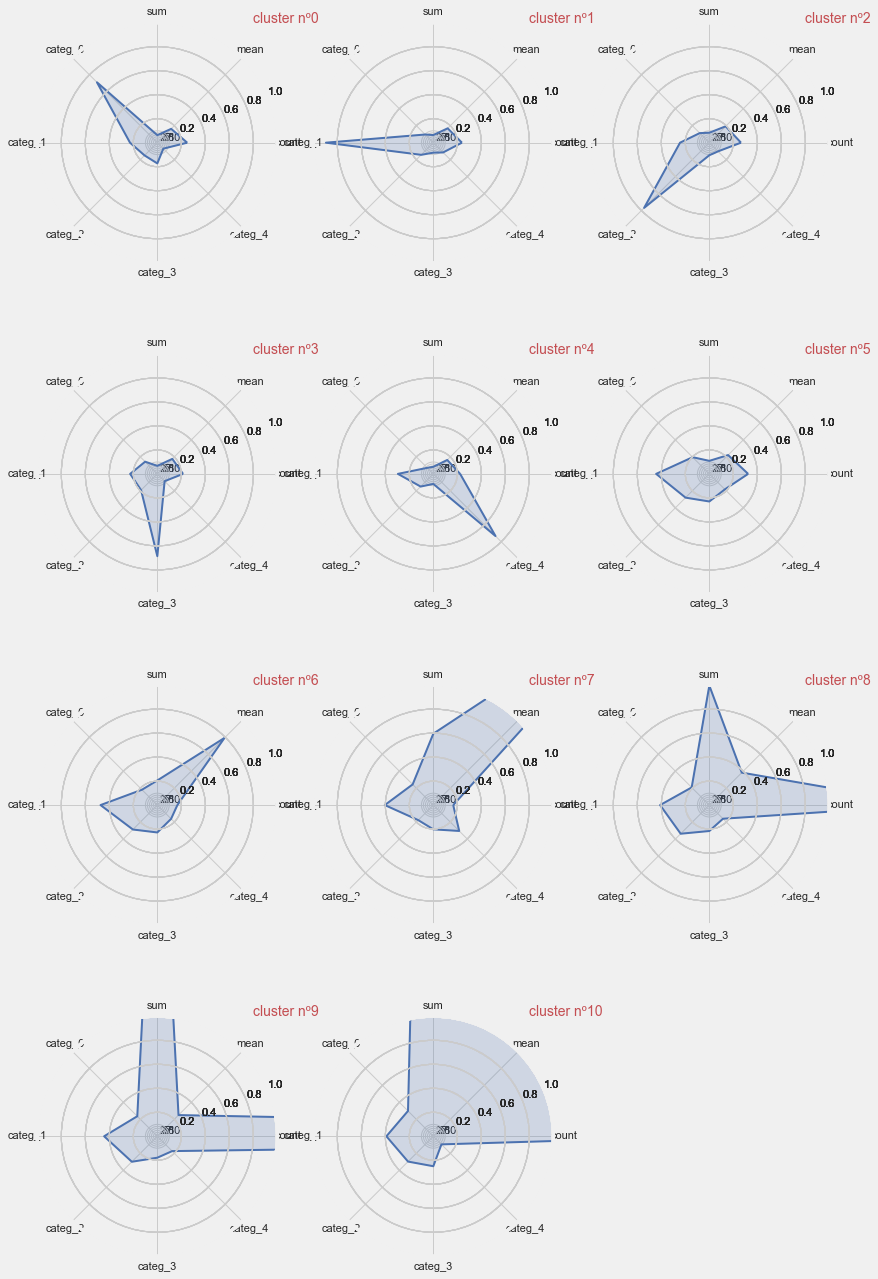

In [64]:
fig = plt.figure(figsize=(10,12))

attributes = ['count', 'mean', 'sum', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4']
ranges = [[0.01, 10], [0.01, 1500], [0.01, 10000], [0.01, 75], [0.01, 75], [0.01, 75], [0.01, 75], [0.01, 75]]
index  = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

n_groups = n_clusters ; i_cols = 3
i_rows = n_groups//i_cols
size_x, size_y = (1/i_cols), (1/i_rows)

for ind in range(n_clusters):
    ix = ind%3 ; iy = i_rows - ind//3
    pos_x = ix*(size_x + 0.05) ; pos_y = iy*(size_y + 0.05)            
    location = [pos_x, pos_y]  ; sizes = [size_x, size_y] 
    #______________________________________________________
    data = np.array(merged_df.loc[index[ind], attributes])    
    radar = RadarChart(fig, location, sizes, attributes, ranges)
    radar.plot(data, color = 'b', linewidth=2.0)
    radar.fill(data, alpha = 0.2, color = 'b')
    radar.title(title = 'cluster nº{}'.format(index[ind]), color = 'r')
    ind += 1

It can be seen, for example, that the first 5 clusters correspond to a strong preponderance of purchases in a particular category of products. Other clusters will differ from basket averages (** mean **), the total sum spent by the clients (** sum **) or the total number of visits made (** count **).

____
## 5. Classification of customers

In this part, the objective will be to adjust a classifier that will classify consumers in the different client categories that were established in the previous section. The objective is to make this classification possible at the first visit. To fulfill this objective, we will test several classifiers implemented in `scikit-learn`. First, in order to simplify their use, we define a class that allows to interface several of the functionalities common to these different classifiers: 

In [65]:
class Class_Fit(object):
    def __init__(self, clf, params=None):
        if params:            
            self.clf = clf(**params)
        else:
            self.clf = clf()

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def grid_search(self, parameters, Kfold):
        self.grid = GridSearchCV(estimator = self.clf, param_grid = parameters, cv = Kfold)
        
    def grid_fit(self, X, Y):
        self.grid.fit(X, Y)
        
    def grid_predict(self, X, Y):
        self.predictions = self.grid.predict(X)
        print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(Y, self.predictions)))
        

Since the goal is to define the class to which a client belongs and this, as soon as its first visit, we only keep the variables that describe the content of the basket, and do not take into account the variables related to the frequency of visits or variations of the basket price over time:

In [66]:
columns = ['mean', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4' ]
X = selected_customers[columns]
Y = selected_customers['cluster']

Finally, we split the dataset in train and test sets:

In [67]:
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, train_size = 0.8)

___
### 5.1 Support Vector Machine Classifier (SVC)

The first classifier that we use is the SVC classifier. In order to use it, create an instance of the `Class_Fit` class and then call` grid_search()`. When calling this method, provide as parameters:
- the hyperparameters for which we will seek an optimal value
- the number of folds to be used for cross-validation

In [68]:
svc = Class_Fit(clf = svm.LinearSVC)
svc.grid_search(parameters = [{'C':np.logspace(-2,2,10)}], Kfold = 5)

Once this instance is created, we adjust the classifier to the training data:

In [69]:
svc.grid_fit(X = X_train, Y = Y_train)

then we can test the quality of the prediction with respect to the test data:

In [70]:
svc.grid_predict(X_test, Y_test)

Precision: 83.52 % 


___
#### 5.1.1 Confusion matrix

The accuracy of the results seems to be correct. Nevertheless, let us remember that when the different classes were defined, there was an imbalance in size between the classes obtained. In particular, one class contains around 40% of the clients. It is therefore interesting to look at how the predictions and real values compare to the breasts of the different classes. This is the subject of the confusion matrices and to represent them, we use the code of the [sklearn documentation](http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html):

In [71]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    #_________________________________________________
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
    #_________________________________________________
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    #_________________________________________________
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

from which we create the following representation:

Confusion matrix, without normalization


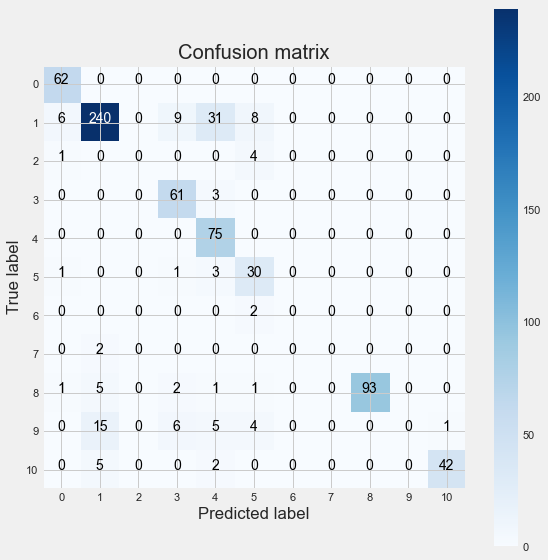

In [72]:
class_names = [i for i in range(11)]
cnf_matrix = confusion_matrix(Y_test, svc.predictions) 
np.set_printoptions(precision=2)
plt.figure(figsize = (8,8))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize = False, title='Confusion matrix')

___
#### 5.1.2 Learning curve

A typical way to test the quality of a fit is to draw a learning curve. In particular, this type of curves allow to detect possible drawbacks in the model, linked for example to over- or under-fitting. This also shows to which extent the mode could benefit from a larger data sample. In order to draw this curve, we use the [scikit-learn documentation code again](http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr- self-examples-model-selection-pad-learning-curve-py)

In [73]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 10)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

from which we represent the learning curve of the SVC classifier:

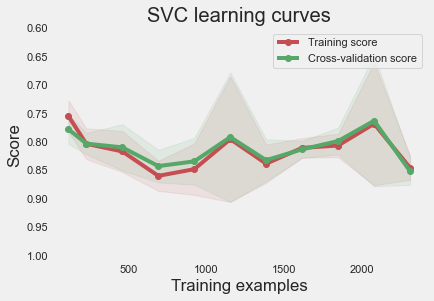

In [74]:
g = plot_learning_curve(svc.grid.best_estimator_,
                        "SVC learning curves", X_train, Y_train, ylim = [1.01, 0.6],
                        cv = 5,  train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5,
                                                0.6, 0.7, 0.8, 0.9, 1])

On this curve, we can see that the train and cross-validation curves converge towards the same limit when the sample size increases. This is typical of modeling with low variance and proves that the model does not suffer from overfitting. Also, we can see that the accuracy of the training curve is correct which is synonymous of a low bias. Hence the model does not underfit the data.

___
### 5.2 Logistic Regression

Now we consider the logistic regression classifier. As before, we create an instance of the `Class_Fit` class, adjust the model on the training data and see how the predictions compare to the real values:

In [75]:
lr = Class_Fit(clf = linear_model.LogisticRegression)
lr.grid_search(parameters = [{'C':np.logspace(-2,2,20)}], Kfold = 5)
lr.grid_fit(X = X_train, Y = Y_train)
lr.grid_predict(X_test, Y_test)

Precision: 91.14 % 


Then, we plot the learning curve to have a feeling of the quality of the model:

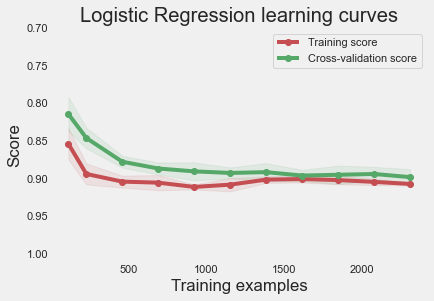

In [76]:
g = plot_learning_curve(lr.grid.best_estimator_, "Logistic Regression learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

### 5.3 k-Nearest Neighbors

In [77]:
knn = Class_Fit(clf = neighbors.KNeighborsClassifier)
knn.grid_search(parameters = [{'n_neighbors': np.arange(1,50,1)}], Kfold = 5)
knn.grid_fit(X = X_train, Y = Y_train)
knn.grid_predict(X_test, Y_test)

Precision: 79.36 % 


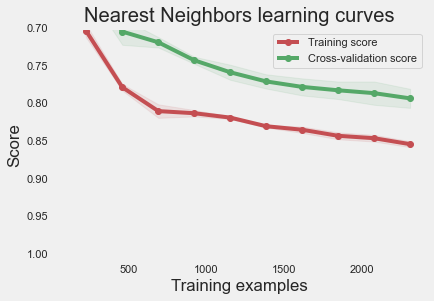

In [78]:
g = plot_learning_curve(knn.grid.best_estimator_, "Nearest Neighbors learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

### 5.4 Decision Tree

In [79]:
tr = Class_Fit(clf = tree.DecisionTreeClassifier)
tr.grid_search(parameters = [{'criterion' : ['entropy', 'gini'], 'max_features' :['sqrt', 'log2']}], Kfold = 5)
tr.grid_fit(X = X_train, Y = Y_train)
tr.grid_predict(X_test, Y_test)

Precision: 83.38 % 


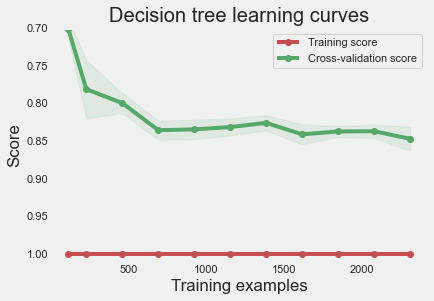

In [80]:
g = plot_learning_curve(tr.grid.best_estimator_, "Decision tree learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

### 5.5 Random Forest

In [81]:
rf = Class_Fit(clf = ensemble.RandomForestClassifier)
param_grid = {'criterion' : ['entropy', 'gini'], 'n_estimators' : [20, 40, 60, 80, 100],
               'max_features' :['sqrt', 'log2']}
rf.grid_search(parameters = param_grid, Kfold = 5)
rf.grid_fit(X = X_train, Y = Y_train)
rf.grid_predict(X_test, Y_test)

Precision: 90.30 % 


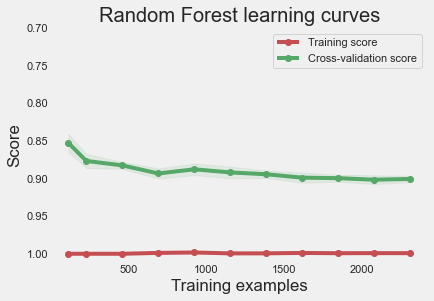

In [82]:
g = plot_learning_curve(rf.grid.best_estimator_, "Random Forest learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

### 5.6 AdaBoost Classifier

In [83]:
ada = Class_Fit(clf = AdaBoostClassifier)
param_grid = {'n_estimators' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}
ada.grid_search(parameters = param_grid, Kfold = 5)
ada.grid_fit(X = X_train, Y = Y_train)
ada.grid_predict(X_test, Y_test)

Precision: 53.32 % 


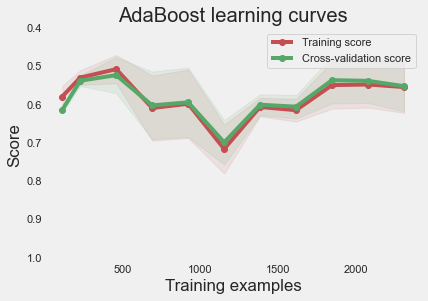

In [84]:
g = plot_learning_curve(ada.grid.best_estimator_, "AdaBoost learning curves", X_train, Y_train,
                        ylim = [1.01, 0.4], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

### 5.7 Gradient Boosting Classifier

In [85]:
gb = Class_Fit(clf = ensemble.GradientBoostingClassifier)
param_grid = {'n_estimators' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}
gb.grid_search(parameters = param_grid, Kfold = 5)
gb.grid_fit(X = X_train, Y = Y_train)
gb.grid_predict(X_test, Y_test)

Precision: 91.00 % 


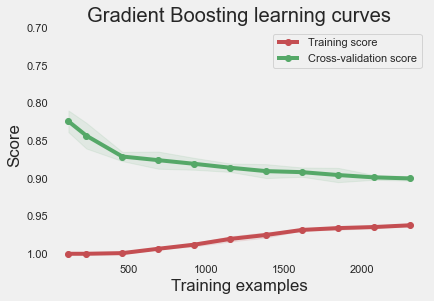

In [86]:
g = plot_learning_curve(gb.grid.best_estimator_, "Gradient Boosting learning curves", X_train, Y_train,
                        ylim = [1.01, 0.7], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

___
### 5.8 Let's vote !(Ensemble Methods)

Finally, the results of the different classifiers presented in the previous sections can be combined to improve the classification model. This can be achieved by selecting the customer category as the one indicated by the majority of classifiers. To do this, we use the `VotingClassifier` method of the `sklearn` package. As a first step, we adjust the parameters of the various classifiers using the *best* parameters previously found:

In [87]:
rf_best  = ensemble.RandomForestClassifier(**rf.grid.best_params_)
gb_best  = ensemble.GradientBoostingClassifier(**gb.grid.best_params_)
svc_best = svm.LinearSVC(**svc.grid.best_params_)
tr_best  = tree.DecisionTreeClassifier(**tr.grid.best_params_)
knn_best = neighbors.KNeighborsClassifier(**knn.grid.best_params_)
lr_best  = linear_model.LogisticRegression(**lr.grid.best_params_)

Then, we define a classifier that merges the results of the various classifiers:

In [88]:
votingC = ensemble.VotingClassifier(estimators=[('rf', rf_best),('gb', gb_best),
                                                ('knn', knn_best)], voting='soft')    

and train it:

In [89]:
votingC = votingC.fit(X_train, Y_train)

Finally, we can create a prediction for this model:

In [90]:
predictions = votingC.predict(X_test)
print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(Y_test, predictions)))

Precision: 91.41 % 


Note that when defining the `votingC` classifier, we only used a sub-sample of the whole set of classifiers defined above and only retained the *Random Forest*, the *k-Nearest Neighbors* and the *Gradient Boosting* classifiers. In practice, this choice has been done with respect to the performance of the classification carried out in the next section.

___
## 6. Testing predictions

In the previous section, a few classifiers were trained in order to categorize customers. Until that point, the whole analysis was based on the data of the first 10 months. In this section, we test the model on the last two months of the dataset, that has been stored in the `set_test` dataframe:

In [91]:
basket_price = set_test.copy(deep = True)

In [92]:
transactions_per_user=basket_price.groupby(by=['CustomerID'])['Basket Price'].agg(['count','min','max','mean','sum'])

for i in range(5):
    col = 'categ_{}'.format(i)
    transactions_per_user.loc[:,col] = basket_price.groupby(by=['CustomerID'])[col].sum() /\
                                            transactions_per_user['sum']*100

transactions_per_user.reset_index(drop = False, inplace = True)
basket_price.groupby(by=['CustomerID'])['categ_0'].sum()

#_______________________
# Correcting time range
transactions_per_user['count'] = 5 * transactions_per_user['count']
transactions_per_user['sum']   = transactions_per_user['count'] * transactions_per_user['mean']

transactions_per_user.sort_values('CustomerID', ascending = True)[:5]

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4
0,12347,10,224.82,1294.32,759.57,7595.70,5.634767,25.053649,32.343299,24.271627,12.696657
1,12349,5,1757.55,1757.55,1757.55,8787.75,20.389178,52.138488,12.245455,10.713778,4.513101
2,12352,5,311.73,311.73,311.73,1558.65,17.290604,60.084047,8.735123,7.217785,6.672441
3,12356,5,58.35,58.35,58.35,291.75,0.000000,100.000000,0.000000,0.000000,0.000000
4,12357,5,6207.67,6207.67,6207.67,31038.35,25.189000,26.686341,14.684737,28.350089,5.089832


Then, we convert the dataframe into a matrix and retain only variables that define the category to which consumers belong. At this level, we recall the method of normalization that had been used on the training set:

In [93]:
list_cols = ['count','min','max','mean','categ_0','categ_1','categ_2','categ_3','categ_4']
#_____________________________________________________________
matrix_test = transactions_per_user[list_cols].values
scaled_test_matrix = scaler.transform(matrix_test)

Each line in this matrix contains a consumer's buying habits. At this stage, it is a question of using these habits in order to define the category to which the consumer belongs. These categories have been established in Section 4. ** At this stage, it is important to bear in mind that this step does not correspond to the classification stage itself**. Here, we prepare the test data by defining the category to which the customers belong. However, this definition uses data obtained over a period of 2 months (via the variables ** count **, ** min **, ** max ** and ** sum **). The classifier defined in Section 5 uses a more restricted set of variables that will be defined from the first purchase of a client.

Here it is a question of using the available data over a period of two months and using this data to define the category to which the customers belong. Then, the classifier can be tested by comparing its predictions with these categories. In order to define the category to which the clients belong, we recall the instance of the `kmeans` method used in section 4. The` predict` method of this instance calculates the distance of the consumers from the centroids of the 11 client classes and the smallest distance will define the belonging to the different categories:

In [94]:
Y = kmeans.predict(scaled_test_matrix)

Finally, in order to prepare the execution of the classifier, it is sufficient to select the variables on which it acts:

In [95]:
columns = ['mean', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4' ]
X = transactions_per_user[columns]

It remains only to examine the predictions of the different classifiers that have been trained in section 5:

In [96]:
classifiers = [(svc, 'Support Vector Machine'),
                (lr, 'Logistic Regression'),
                (knn, 'k-Nearest Neighbors'),
                (tr, 'Decision Tree'),
                (rf, 'Random Forest'),
                (gb, 'Gradient Boosting')]
#______________________________
for clf, label in classifiers:
    print(30*'_', '\n{}'.format(label))
    clf.grid_predict(X, Y)

______________________________ 
Support Vector Machine
Precision: 71.11 % 
______________________________ 
Logistic Regression
Precision: 76.48 % 
______________________________ 
k-Nearest Neighbors
Precision: 67.89 % 
______________________________ 
Decision Tree
Precision: 71.70 % 
______________________________ 
Random Forest
Precision: 75.15 % 
______________________________ 
Gradient Boosting
Precision: 75.77 % 


Finally, as anticipated in Section 5.8, it is possible to improve the quality of the classifier by combining their respective predictions. At this level, we choose to mix *Random Forest*, *Gradient Boosting* and *k-Nearest Neighbors* predictions because this leads to a slight improvement in predictions:

In [97]:
predictions = votingC.predict(X)
print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(Y, predictions)))

Precision: 76.32 % 


# Conclusion

The work presented herein details a comprehensive methodology for analyzing and predicting customer behavior within an e-commerce environment. Commencing with the classification of products into five key categories, we proceeded to segment our customer base into eleven distinct profiles based on their purchasing habits over a ten-month interval, considering product preferences, visit frequency, and spending patterns. We then trained and evaluated several classifiers to predict these customer segments using only the data from their initial purchase, specifically the mean basket value and the percentage of expenditure across the five product categories. Our evaluation, conducted on the subsequent two months of data, yielded a classification accuracy of 75%, indicating a reasonably effective model. However, we acknowledge a significant potential bias arising from the seasonality of purchases. The customer segments defined over a ten-month period may not entirely reflect purchasing behaviors during different periods, such as peak holiday seasons. To mitigate this limitation, future investigations should focus on acquiring and analyzing data spanning a longer duration to capture and model these seasonal effects, thereby leading to a more accurate and reliable predictive framework for customer behavior.